<a href="https://www.kaggle.com/code/ashishg2002/product-recommendor-system?scriptVersionId=127013702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Basic Libraries
import numpy as np
import pandas as pd

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Text Handling Libraries
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [2]:
df = pd.read_csv('../input/bigbasket-entire-product-list-28k-datapoints/BigBasket Products.csv',index_col='index')

In [3]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [4]:
df.shape

(27555, 9)

In [5]:
df.isnull().sum()

product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

In [6]:
print('Total Null Data')
null_count = df.isnull().sum().sum()
total_count = np.product(df.shape)
print("{:.2f}".format(null_count/total_count * 100))

Total Null Data
3.53


So overall 3% data is missing but 31% of ratings are missing. Since we are going to create a recommender system, let's drop the null values as their will still be over 69% data for recommendation purposes which is enough for us.

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

product         0
category        0
sub_category    0
brand           0
sale_price      0
market_price    0
type            0
rating          0
description     0
dtype: int64

In [9]:
df.shape

(18840, 9)

In [10]:
# df.to_csv('data_cleaned.csv')

So even after dropping null data, 18000+ products are available for recommendation.
Let's recommend now!!

**Exploratory Data Analysis!!**


In [11]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [12]:
counts = df['category'].value_counts()

counts_df = pd.DataFrame({'Category':counts.index,'Counts':counts.values})

In [13]:
px.bar(data_frame=counts_df,
 x='Category',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Count of Items in Each Category')

In [14]:
counts = df['sub_category'].value_counts()

counts_df_1 = pd.DataFrame({'Category':counts.index,'Counts':counts.values})[:10]

In [15]:
px.bar(data_frame=counts_df_1,
 x='Category',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Top 10 Bought Sub_Categories')

In [16]:
counts = df['brand'].value_counts()

counts_df_brand = pd.DataFrame({'Brand Name':counts.index,'Counts':counts.values})[:10]

In [17]:
px.bar(data_frame=counts_df_brand,
 x='Brand Name',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Top 10 Brand Items based on Item Counts')


In [18]:
counts = df['type'].value_counts()

counts_df_type = pd.DataFrame({'Type':counts.index,'Counts':counts.values})[:10]

In [19]:
px.bar(data_frame=counts_df_type,
 x='Type',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Top 10 Types of Products based on Item Counts')

**DEMOGRAPHIC FILTERING!!**

Demographic Filtering is like recommeding items based on a feature. Like the top 10 rated items or the top 10 items in a particular category.

In [20]:
def sort_recommendor(col='rating',sort_type = False):
    """
    A recommendor based on sorting products on the column passed.
    Arguments to be passed:
    
    col: The Feature to be used for recommendation.
    sort_type: True for Ascending Order
    """
    rated_recommend = df.copy()
    if rated_recommend[col].dtype == 'O':
        col='rating'
    rated_recommend = rated_recommend.sort_values(by=col,ascending = sort_type)
    return rated_recommend[['product','brand','sale_price','rating']].head(10)

In [21]:
help(sort_recommendor)

Help on function sort_recommendor in module __main__:

sort_recommendor(col='rating', sort_type=False)
    A recommendor based on sorting products on the column passed.
    Arguments to be passed:
    
    col: The Feature to be used for recommendation.
    sort_type: True for Ascending Order



In [22]:
sort_recommendor(col='sale_price',sort_type=True)

,product,brand,sale_price,rating
index,,,,
21313,Serum,Livon,3.0,2.5
18291,Sugar Coated Chocolate,Cadbury Gems,5.0,4.2
21229,Dish Shine Bar,Exo,5.0,4.2
14539,Cadbury Perk - Chocolate Bar,Cadbury,5.0,4.2
19539,Layer Cake - Chocolate,Winkies,5.0,4.2
2979,Sugar Free Chewing Gum - Mixed Fruit,Orbit,5.0,4.2
15927,Dreams Cup Cake - Choco,Elite,5.0,3.9
6015,Good Day Butter Cookies,Britannia,5.0,4.1
27414,Layer Cake - Orange,Winkies,5.0,4.1


Notice that our top product has rating of 2.5 which is quite bad so let's filter down by setting a threshold rating.

In [23]:
C= df['rating'].mean()
C

3.9430626326963902

So the average rating of products is 3.94 Let's use 3.5 as the threshold.

In [24]:
def sort_recommendor(col='rating',sort_type = False):
    """
    A recommendor based on sorting products on the column passed.
    Arguments to be passed:
    
    col: The Feature to be used for recommendation.
    sort_type: True for Ascending Order
    """
    rated_recommend = df.copy().loc[df['rating'] >= 3.5]
    if rated_recommend[col].dtype == 'O':
        col='rating'
    rated_recommend = rated_recommend.sort_values(by=col,ascending = sort_type)
    return rated_recommend[['product','brand','sale_price','rating']].head(10)

In [25]:
sort_recommendor(col='sale_price',sort_type=True)

,product,brand,sale_price,rating
index,,,,
2762,Orbit Sugar-Free Chewing Gum - Lemon & Lime,Wrigleys,5.0,4.2
3446,Marie Light Biscuits - Active,Sunfeast,5.0,4.5
14604,50-50 Timepass Biscuits,Britannia,5.0,3.9
17641,Hand Wash - Moisture Shield,Savlon,5.0,4.4
27491,50-50 Timepass Salted Biscuits,Britannia,5.0,4.2
26585,Polo - The Mint With The Hole,Nestle,5.0,4.4
2979,Sugar Free Chewing Gum - Mixed Fruit,Orbit,5.0,4.2
19539,Layer Cake - Chocolate,Winkies,5.0,4.2
19203,Bounce Biscuits - Choco Creme,Sunfeast,5.0,4.2


Notice that the 2.5 rated product is not recommended now!! This was our first recommendor.
Quite easy yet effective and used a lot !!

**CONTENT BASED RECOMMMENDOR!!**

In [26]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


We will be using NLP here to extract useful info from the features especially Description so let's understand TF-IDF before using it.

TF-IDF stands for term frequency-inverse document frequency.

What is TF(Term Frequency):

Term frequency works by looking at the frequency of a particular term you are concerned with relative to the document. There are multiple measures, or ways, of defining frequency: Number of times the word appears in a document (raw count).

Term frequency adjusted for the length of the document (raw count of occurences divided by number of words in the document). Logarithmically scaled frequency (e.g. log(1 + raw count)). Boolean frequency (e.g. 1 if the term occurs, or 0 if the term does not occur, in the document).

What is IDF (inverse document frequency)?

Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where t is the term (word) we are looking to measure the commonness of and N is the number of documents (d) in the corpus (D)..
The denominator is simply the number of documents in which the term, t, appears in.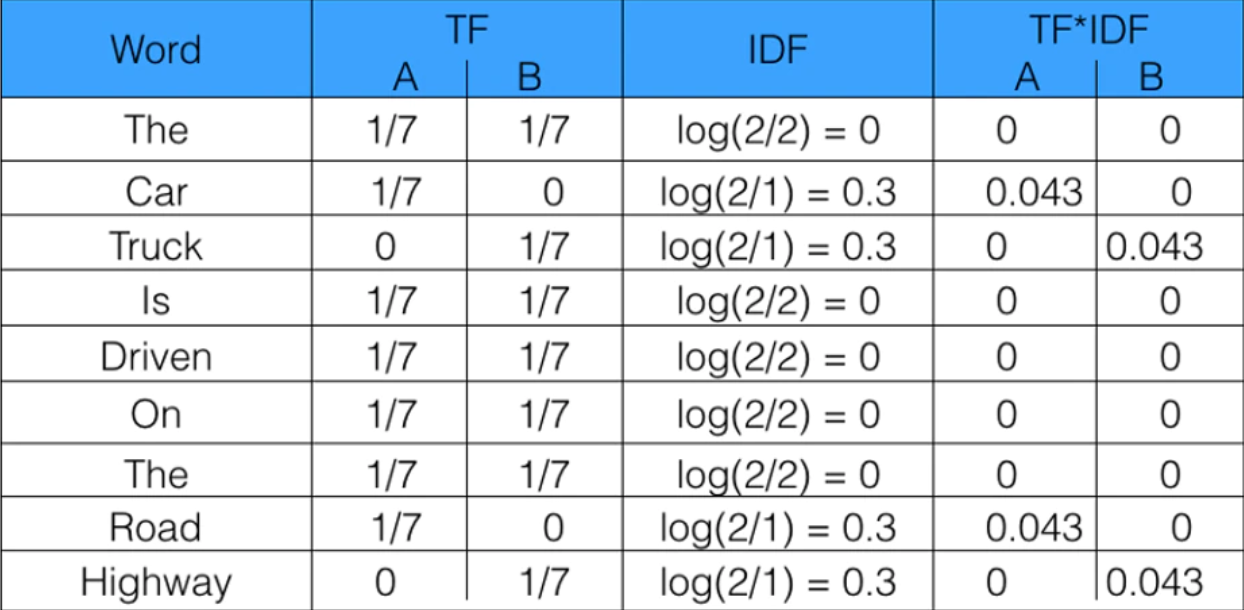

In [27]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])
tfidf_matrix.shape

(18840, 23342)

Now to compute the similarity score, let's use Linear_Kernel.
Linear Kernel which Calculates the Dot Product of the tfidf_matrix and returns an aggreate value depicting the Similarity score.

In [28]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.01632718, 0.00999603, ..., 0.01056047, 0.01133156,
        0.        ],
       [0.01632718, 1.        , 0.00719713, ..., 0.        , 0.        ,
        0.        ],
       [0.00999603, 0.00719713, 1.        , ..., 0.00635776, 0.        ,
        0.        ],
       ...,
       [0.01056047, 0.        , 0.00635776, ..., 1.        , 0.        ,
        0.        ],
       [0.01133156, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

So we will be recommending items based on similarity score.
But our problem is that we will be getting back the similarity scores so we will be sorting the scores.
Now we need a reverse-map to get the title and that is what indices is for.

In [29]:
indices = pd.Series(df.index, index=df['product']).drop_duplicates()

def get_recommendations_1(title, cosine_sim=cosine_sim):
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['product'].iloc[movie_indices]

In [30]:
get_recommendations_1('Water Bottle - Orange')

index
1677         Brass Nanda Stand Goblets - No.1
2162         Brass Kachua Stand Deepam - No.1
2756     Brass Angle Deep Stand - Plain, No.2
5400       Brass Lakshmi Deepam - Plain, No.2
6520                Brass Kuber Deepam - No.1
10504               Brass Kuber Deepam - No.2
11226    Brass Angle Deep Stand - Plain, No.3
11504    Brass Angle Deep Stand - Plain, No.1
12699        Brass Kachua Stand Deepam - No.2
18572               Brass Kuber Deepam - No.3
Name: product, dtype: object

In [31]:
get_recommendations_1('Cadbury Perk - Chocolate Bar')

index
27049                        Pickle - Mixed
6601                  Pickle - Kaduku Mango
17934                Pickle - Mix Vegetable
27105                        Pickle - Prawn
3962                  Pickle - Tender Mango
16875             Olive Oil - Carrot Pickle
3444                     Pickle - Cut Mango
17237      Andhra Special Red Chilli Pickle
27234    Pickle - Lime (South Indian Style)
4955                    Pickle - Gooseberry
Name: product, dtype: object

Our search was chocolate yet we got Cashews and Nuts recommended.
We need to optimize this based on category, sub_category and brand.

In [32]:
df2 = df.copy()

In [33]:
df2.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [34]:
df2.shape

(18840, 9)

In [35]:
rmv_spc = lambda a:a.strip()
get_list = lambda a:list(map(rmv_spc,re.split('& |, |\*|\n', a)))

In [36]:
get_list('A & B, C')

['A', 'B', 'C']

In [37]:
for col in ['category', 'sub_category', 'type']:
    df2[col] = df2[col].apply(get_list)

In [38]:
df2.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,"[Beauty, Hygiene]",[Hair Care],Sri Sri Ayurveda,220.0,220.0,"[Hair Oil, Serum]",4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"[Kitchen, Garden, Pets]","[Storage, Accessories]",Mastercook,180.0,180.0,"[Water, Fridge Bottles]",2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2","[Cleaning, Household]",[Pooja Needs],Trm,119.0,250.0,"[Lamp, Lamp Oil]",3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,"[Cleaning, Household]","[Bins, Bathroom Ware]",Nakoda,149.0,176.0,"[Laundry, Storage Baskets]",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,"[Beauty, Hygiene]","[Bath, Hand Wash]",Nivea,162.0,162.0,"[Bathing Bars, Soaps]",4.4,Nivea Creme Soft Soap gives your skin the best...


To avoid duplicacy, we will be converting everything to lowercase and also removing spaces between words.
This will ensure that our recommendor doesn't consider Chocolate of Cholocate IceCream and Chocolate Bar as the same.

In [39]:
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [40]:
for col in ['category', 'sub_category', 'type','brand']:
    df2[col] = df2[col].apply(cleaner)

In [41]:
df2.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,"[beauty, hygiene]",[haircare],srisriayurveda,220.0,220.0,"[hairoil, serum]",4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"[kitchen, garden, pets]","[storage, accessories]",mastercook,180.0,180.0,"[water, fridgebottles]",2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2","[cleaning, household]",[poojaneeds],trm,119.0,250.0,"[lamp, lampoil]",3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,"[cleaning, household]","[bins, bathroomware]",nakoda,149.0,176.0,"[laundry, storagebaskets]",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,"[beauty, hygiene]","[bath, handwash]",nivea,162.0,162.0,"[bathingbars, soaps]",4.4,Nivea Creme Soft Soap gives your skin the best...


In [42]:
def couple(x):
    return ' '.join(x['category']) + ' ' + ' '.join(x['sub_category']) + ' '+x['brand']+' ' +' '.join( x['type'])
df2['soup'] = df2.apply(couple, axis=1)

In [43]:
df2['soup'].head()

index
1    beauty hygiene haircare srisriayurveda hairoil...
2    kitchen garden pets storage accessories master...
3       cleaning household poojaneeds trm lamp lampoil
4    cleaning household bins bathroomware nakoda la...
5    beauty hygiene bath handwash nivea bathingbars...
Name: soup, dtype: object

We need to Count the String Vectors and then compute the Cosine Similarity Score.

In [44]:
df2.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,soup
index,,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,"[beauty, hygiene]",[haircare],srisriayurveda,220.0,220.0,"[hairoil, serum]",4.1,This Product contains Garlic Oil that is known...,beauty hygiene haircare srisriayurveda hairoil...
2,Water Bottle - Orange,"[kitchen, garden, pets]","[storage, accessories]",mastercook,180.0,180.0,"[water, fridgebottles]",2.3,"Each product is microwave safe (without lid), ...",kitchen garden pets storage accessories master...
3,"Brass Angle Deep - Plain, No.2","[cleaning, household]",[poojaneeds],trm,119.0,250.0,"[lamp, lampoil]",3.4,"A perfect gift for all occasions, be it your m...",cleaning household poojaneeds trm lamp lampoil
4,Cereal Flip Lid Container/Storage Jar - Assort...,"[cleaning, household]","[bins, bathroomware]",nakoda,149.0,176.0,"[laundry, storagebaskets]",3.7,Multipurpose container with an attractive desi...,cleaning household bins bathroomware nakoda la...
5,Creme Soft Soap - For Hands & Body,"[beauty, hygiene]","[bath, handwash]",nivea,162.0,162.0,"[bathingbars, soaps]",4.4,Nivea Creme Soft Soap gives your skin the best...,beauty hygiene bath handwash nivea bathingbars...


In [45]:
df2.to_csv('data_cleaned_1.csv')

In [46]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

We need to Count the String Vectors and then compute the Cosine Similarity Score.

In [47]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
cosine_sim2

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.27216553],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.27216553, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [48]:
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['product'])

In [49]:
def get_recommendations_2(title, cosine_sim=cosine_sim):
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    return df2['product'].iloc[movie_indices]

Comparing Old and New Recommedations

In [50]:
old_rec = get_recommendations_1('Water Bottle - Orange').values
new_rec = get_recommendations_2('Water Bottle - Orange', cosine_sim2).values

pd.DataFrame({'Old Recommendor': old_rec,'New Recommendor':new_rec})

,Old Recommendor,New Recommendor
0,"Rectangular Plastic Container - With Lid, Mult...",Glass Water Bottle - Aquaria Organic Purple
1,"Jar - With Lid, Yellow",Glass Water Bottle With Round Base - Transpare...
2,"Round & Flat Storage Container - With lid, Green",H2O Unbreakable Water Bottle - Pink
3,Premium Rectangular Plastic Container With Lid...,Water Bottle H2O Purple
4,Premium Round Plastic Container With Lid - Yellow,H2O Unbreakable Water Bottle - Green
5,Premium Rectangular Plastic Container With Lid...,Regel Tritan Plastic Sports Water Bottle - Black
6,Premium Round & Flat Storage Container With Li...,Apsara 1 Water Bottle - Assorted Colour
7,Premium Round Plastic Container With Lid - Blue,"Glass Water Bottle With Round Base - Yellow, B..."
8,Premium Round Plastic Container With Lid - Mul...,Trendy Stainless Steel Bottle With Steel Cap -...
9,Premium Round Plastic Container With Lid - Pink,"Penta Plastic Pet Water Bottle - Violet, Wide ..."


In [51]:
old_rec = get_recommendations_1('Cadbury Perk - Chocolate Bar').values
new_rec = get_recommendations_2('Cadbury Perk - Chocolate Bar', cosine_sim2).values

pd.DataFrame({'Old Recommendor': old_rec,'New Recommendor':new_rec})

,Old Recommendor,New Recommendor
0,Cadbury Perk - Chocolate Bar,Nutties Chocolate Pack
1,Choco Stick - Hexagon Pack,5 Star Chocolate Bar
2,Luvit Chocwich White Home Delights 187 g,Dairy Milk Silk - Hazelnut Chocolate Bar
3,Luvit Chocwich Home Delights 187 g,"Perk - Chocolate, Home Treats, 175.5 g, 27 Units"
4,Wafer Biscuits - Chocolate Flavor,Dark Milk Chocolate Bar
5,Drinking Chocolate - Original,Dairy Milk Silk Mousse - Chocolate Bar
6,Drinking Chocolate - Original,Dark Milk Chocolate Bar
7,Biscuit - Bourbon Creams,Chocolate Bar - Fuse
8,Wafers With Hazelnut Cream,Choclairs Gold Coffee
9,Choco Stick - Chocolate,"5 Star Chocolate Home Pack, 200 g, 20 units"


Our new recommendation are much better compared to the old ones.